In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import scanpy as sc
import omicverse as ov
import anndata as ad
import muon as mu
from muon import MuData 
import mofax as mfx

from gprofiler import GProfiler

In [ ]:
rna_df = pd.read_csv('rna_seq_ready.csv', index_col=0)
proteome_df = pd.read_csv('proteome_ready.csv', index_col=0)
scnv_df = pd.read_csv('scnv_ready.csv', index_col=0)
mutation_df = pd.read_csv('mutation_ready.csv', index_col=0)
clinical_data_df = pd.read_csv('clinical_data_ready.csv', index_col=0)

In [12]:
print("rna_df: ", rna_df.info())
print("proteome_df: ", proteome_df.info())
print("scnv_df: ", scnv_df.info())
print("mutation_df: ", mutation_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 10734 entries, A2M to ZZZ3
Columns: 122 entries, CPT000814 to X22BR006
dtypes: float64(122)
memory usage: 10.1+ MB
rna_df:  None
<class 'pandas.core.frame.DataFrame'>
Index: 7747 entries, A1BG to ZZZ3
Columns: 122 entries, CPT000814 to X22BR006
dtypes: float64(122)
memory usage: 7.3+ MB
proteome_df:  None
<class 'pandas.core.frame.DataFrame'>
Index: 23692 entries, DDX11L1 to ZBED4
Columns: 122 entries, CPT000814 to X22BR006
dtypes: float64(122)
memory usage: 22.2+ MB
scnv_df:  None
<class 'pandas.core.frame.DataFrame'>
Index: 9448 entries, A1CF to ZZEF1
Columns: 122 entries, X11BR038 to X14BR014
dtypes: int64(122)
memory usage: 8.9+ MB
mutation_df:  None


In [ ]:
# Transposing (genes -> columns, samples -> rows)
rna_df = rna_df.T
proteome_df = proteome_df.T
scnv_df = scnv_df.T
mutation_df = mutation_df.T

In [ ]:
clinical_columns = [
    'Stage', 'PAM50', 'NMF.cluster', 'PR', 'ER', 'HER2.Amplified',
    'Age.in.Month', 'TNBC.Updated.Clinical.Status', 'Tumor.Cellularity',
    'Total.Cellularity', 'ESTIMATE.TumorPurity', 'ESTIMATE.ImmuneScore',
    'ESTIMATE.StromalScore', 'xCell.ImmuneScore', 'xCell.StromaScore',
    'Cibersort.Absolute.score', 'Stemness.Score', 'Stage.reduced', 
    'CD3.TILS.status', 'CD3.TILS.counts'
]
clinical_df_subset = clinical_data_df[clinical_columns]

In [ ]:
clinical_df_subset_rna = clinical_df_subset.reindex(rna_df.index)
clinical_df_subset_proteome = clinical_df_subset.reindex(proteome_df.index)
clinical_df_subset_scnv = clinical_df_subset.reindex(scnv_df.index)
clinical_df_subset_mutation = clinical_df_subset.reindex(mutation_df.index)

#AnnData objects
rna_adata = sc.AnnData(X=rna_df, obs=clinical_df_subset_rna)
proteome_adata = sc.AnnData(X=proteome_df, obs=clinical_df_subset_proteome)
scnv_adata = sc.AnnData(X=scnv_df, obs=clinical_df_subset_scnv)
mutation_adata = sc.AnnData(X=mutation_df, obs=clinical_df_subset_mutation)


rna_adata.uns["modality"] = "RNA"
proteome_adata.uns["modality"] = "Proteome"
scnv_adata.uns["modality"] = "SCNV"
mutation_adata.uns["modality"] = "Mutation"

In [ ]:
# MuData Object
mdata = MuData({"RNA": rna_adata, "Proteome": proteome_adata, "SCNV": scnv_adata, "Mutation": mutation_adata})

In [29]:
mdata

MuData object with n_obs × n_vars = 122 × 51621
  4 modalities
    RNA:	122 x 10734
      obs:	'Stage', 'PAM50', 'NMF.cluster', 'PR', 'ER', 'HER2.Amplified', 'Age.in.Month', 'TNBC.Updated.Clinical.Status', 'Tumor.Cellularity', 'Total.Cellularity', 'ESTIMATE.TumorPurity', 'ESTIMATE.ImmuneScore', 'ESTIMATE.StromalScore', 'xCell.ImmuneScore', 'xCell.StromaScore', 'Cibersort.Absolute.score', 'Stemness.Score', 'Stage.reduced', 'CD3.TILS.status', 'CD3.TILS.counts'
      uns:	'modality'
    Proteome:	122 x 7747
      obs:	'Stage', 'PAM50', 'NMF.cluster', 'PR', 'ER', 'HER2.Amplified', 'Age.in.Month', 'TNBC.Updated.Clinical.Status', 'Tumor.Cellularity', 'Total.Cellularity', 'ESTIMATE.TumorPurity', 'ESTIMATE.ImmuneScore', 'ESTIMATE.StromalScore', 'xCell.ImmuneScore', 'xCell.StromaScore', 'Cibersort.Absolute.score', 'Stemness.Score', 'Stage.reduced', 'CD3.TILS.status', 'CD3.TILS.counts'
      uns:	'modality'
    SCNV:	122 x 23692
      obs:	'Stage', 'PAM50', 'NMF.cluster', 'PR', 'ER', 'HER2.Amplified', 'Age.in.Month', 'TNBC.Updated.Clinical.Status', 'Tumor.Cellularity', 'Total.Cellularity', 'ESTIMATE.TumorPurity', 'ESTIMATE.ImmuneScore', 'ESTIMATE.StromalScore', 'xCell.ImmuneScore', 'xCell.StromaScore', 'Cibersort.Absolute.score', 'Stemness.Score', 'Stage.reduced', 'CD3.TILS.status', 'CD3.TILS.counts'
      uns:	'modality'
    Mutation:	122 x 9448
      obs:	'Stage', 'PAM50', 'NMF.cluster', 'PR', 'ER', 'HER2.Amplified', 'Age.in.Month', 'TNBC.Updated.Clinical.Status', 'Tumor.Cellularity', 'Total.Cellularity', 'ESTIMATE.TumorPurity', 'ESTIMATE.ImmuneScore', 'ESTIMATE.StromalScore', 'xCell.ImmuneScore', 'xCell.StromaScore', 'Cibersort.Absolute.score', 'Stemness.Score', 'Stage.reduced', 'CD3.TILS.status', 'CD3.TILS.counts'
      uns:	'modality'

In [ ]:
mdata.mod['Mutation'].X = mdata.mod['Mutation'].X.astype(np.float64)
mdata.write("mdata_breast_preanalysis.h5ad")

In [ ]:
#
#   RUNNING MOFA INTEGRATION
#

mu.tl.mofa(
    mdata,
    use_obs='union',
    n_factors=15,
    convergence_mode='medium',
    outfile="model_br.hdf5"
)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='RNA' group='group1' with N=122 samples and D=10734 features...
Loaded view='Proteome' group='group1' with N=122 samples and D=7747 features...
Loaded view='SCNV' group='group1' with N=122 samples and D=23692 features...
Loaded view='Mutation' group='group1' with N=122 samples and D=9448 features...


Model options:
- Automatic Relevance Determination prior on the fa

In [ ]:
mdata

MuData object with n_obs × n_vars = 122 × 51621
  uns:	'mofa'
  obsm:	'X_mofa'
  varm:	'LFs'
  4 modalities
    RNA:	122 x 10734
      obs:	'Stage', 'PAM50', 'NMF.cluster', 'PR', 'ER', 'HER2.Amplified', 'Age.in.Month', 'TNBC.Updated.Clinical.Status', 'Tumor.Cellularity', 'Total.Cellularity', 'ESTIMATE.TumorPurity', 'ESTIMATE.ImmuneScore', 'ESTIMATE.StromalScore', 'xCell.ImmuneScore', 'xCell.StromaScore', 'Cibersort.Absolute.score', 'Stemness.Score', 'Stage.reduced', 'CD3.TILS.status', 'CD3.TILS.counts'
      uns:	'modality'
    Proteome:	122 x 7747
      obs:	'Stage', 'PAM50', 'NMF.cluster', 'PR', 'ER', 'HER2.Amplified', 'Age.in.Month', 'TNBC.Updated.Clinical.Status', 'Tumor.Cellularity', 'Total.Cellularity', 'ESTIMATE.TumorPurity', 'ESTIMATE.ImmuneScore', 'ESTIMATE.StromalScore', 'xCell.ImmuneScore', 'xCell.StromaScore', 'Cibersort.Absolute.score', 'Stemness.Score', 'Stage.reduced', 'CD3.TILS.status', 'CD3.TILS.counts'
      uns:	'modality'
    SCNV:	122 x 23692
      obs:	'Stage', 'PAM50', 'NMF.cluster', 'PR', 'ER', 'HER2.Amplified', 'Age.in.Month', 'TNBC.Updated.Clinical.Status', 'Tumor.Cellularity', 'Total.Cellularity', 'ESTIMATE.TumorPurity', 'ESTIMATE.ImmuneScore', 'ESTIMATE.StromalScore', 'xCell.ImmuneScore', 'xCell.StromaScore', 'Cibersort.Absolute.score', 'Stemness.Score', 'Stage.reduced', 'CD3.TILS.status', 'CD3.TILS.counts'
      uns:	'modality'
    Mutation:	122 x 9448
      obs:	'Stage', 'PAM50', 'NMF.cluster', 'PR', 'ER', 'HER2.Amplified', 'Age.in.Month', 'TNBC.Updated.Clinical.Status', 'Tumor.Cellularity', 'Total.Cellularity', 'ESTIMATE.TumorPurity', 'ESTIMATE.ImmuneScore', 'ESTIMATE.StromalScore', 'xCell.ImmuneScore', 'xCell.StromaScore', 'Cibersort.Absolute.score', 'Stemness.Score', 'Stage.reduced', 'CD3.TILS.status', 'CD3.TILS.counts'
      uns:	'modality'

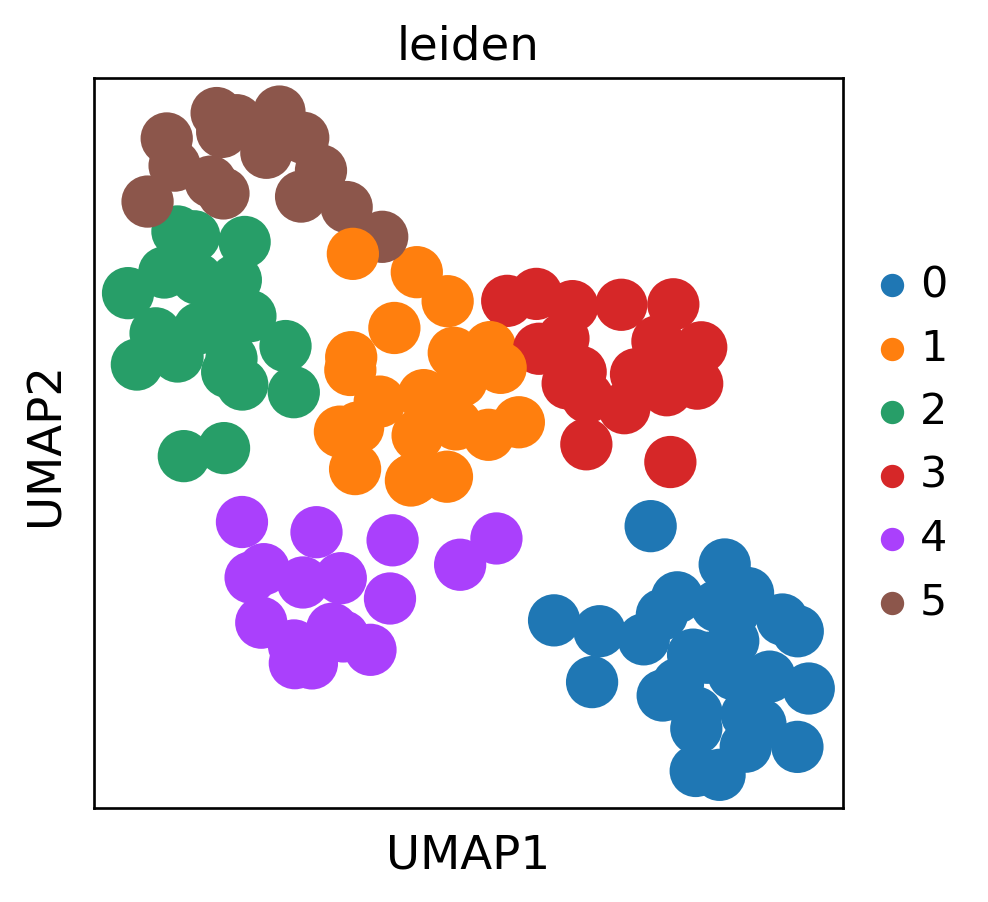

In [ ]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)
sc.tl.leiden(mdata)


sc.pl.umap(mdata, color="leiden", save="mofa2_umap_leiden.png")

## More Postanalysis

In [4]:
model = mfx.mofa_model("model_br.hdf5")
model

MOFA+ model: model br
Samples (cells): 122
Features: 51621
Groups: group1 (122)
Views: Mutation (9448), Proteome (7747), RNA (10734), SCNV (23692)
Factors: 15
Expectations: W, Z

No significant enrichment for Factor_1
No significant enrichment for Factor_2
No significant enrichment for Factor_3
No significant enrichment for Factor_4


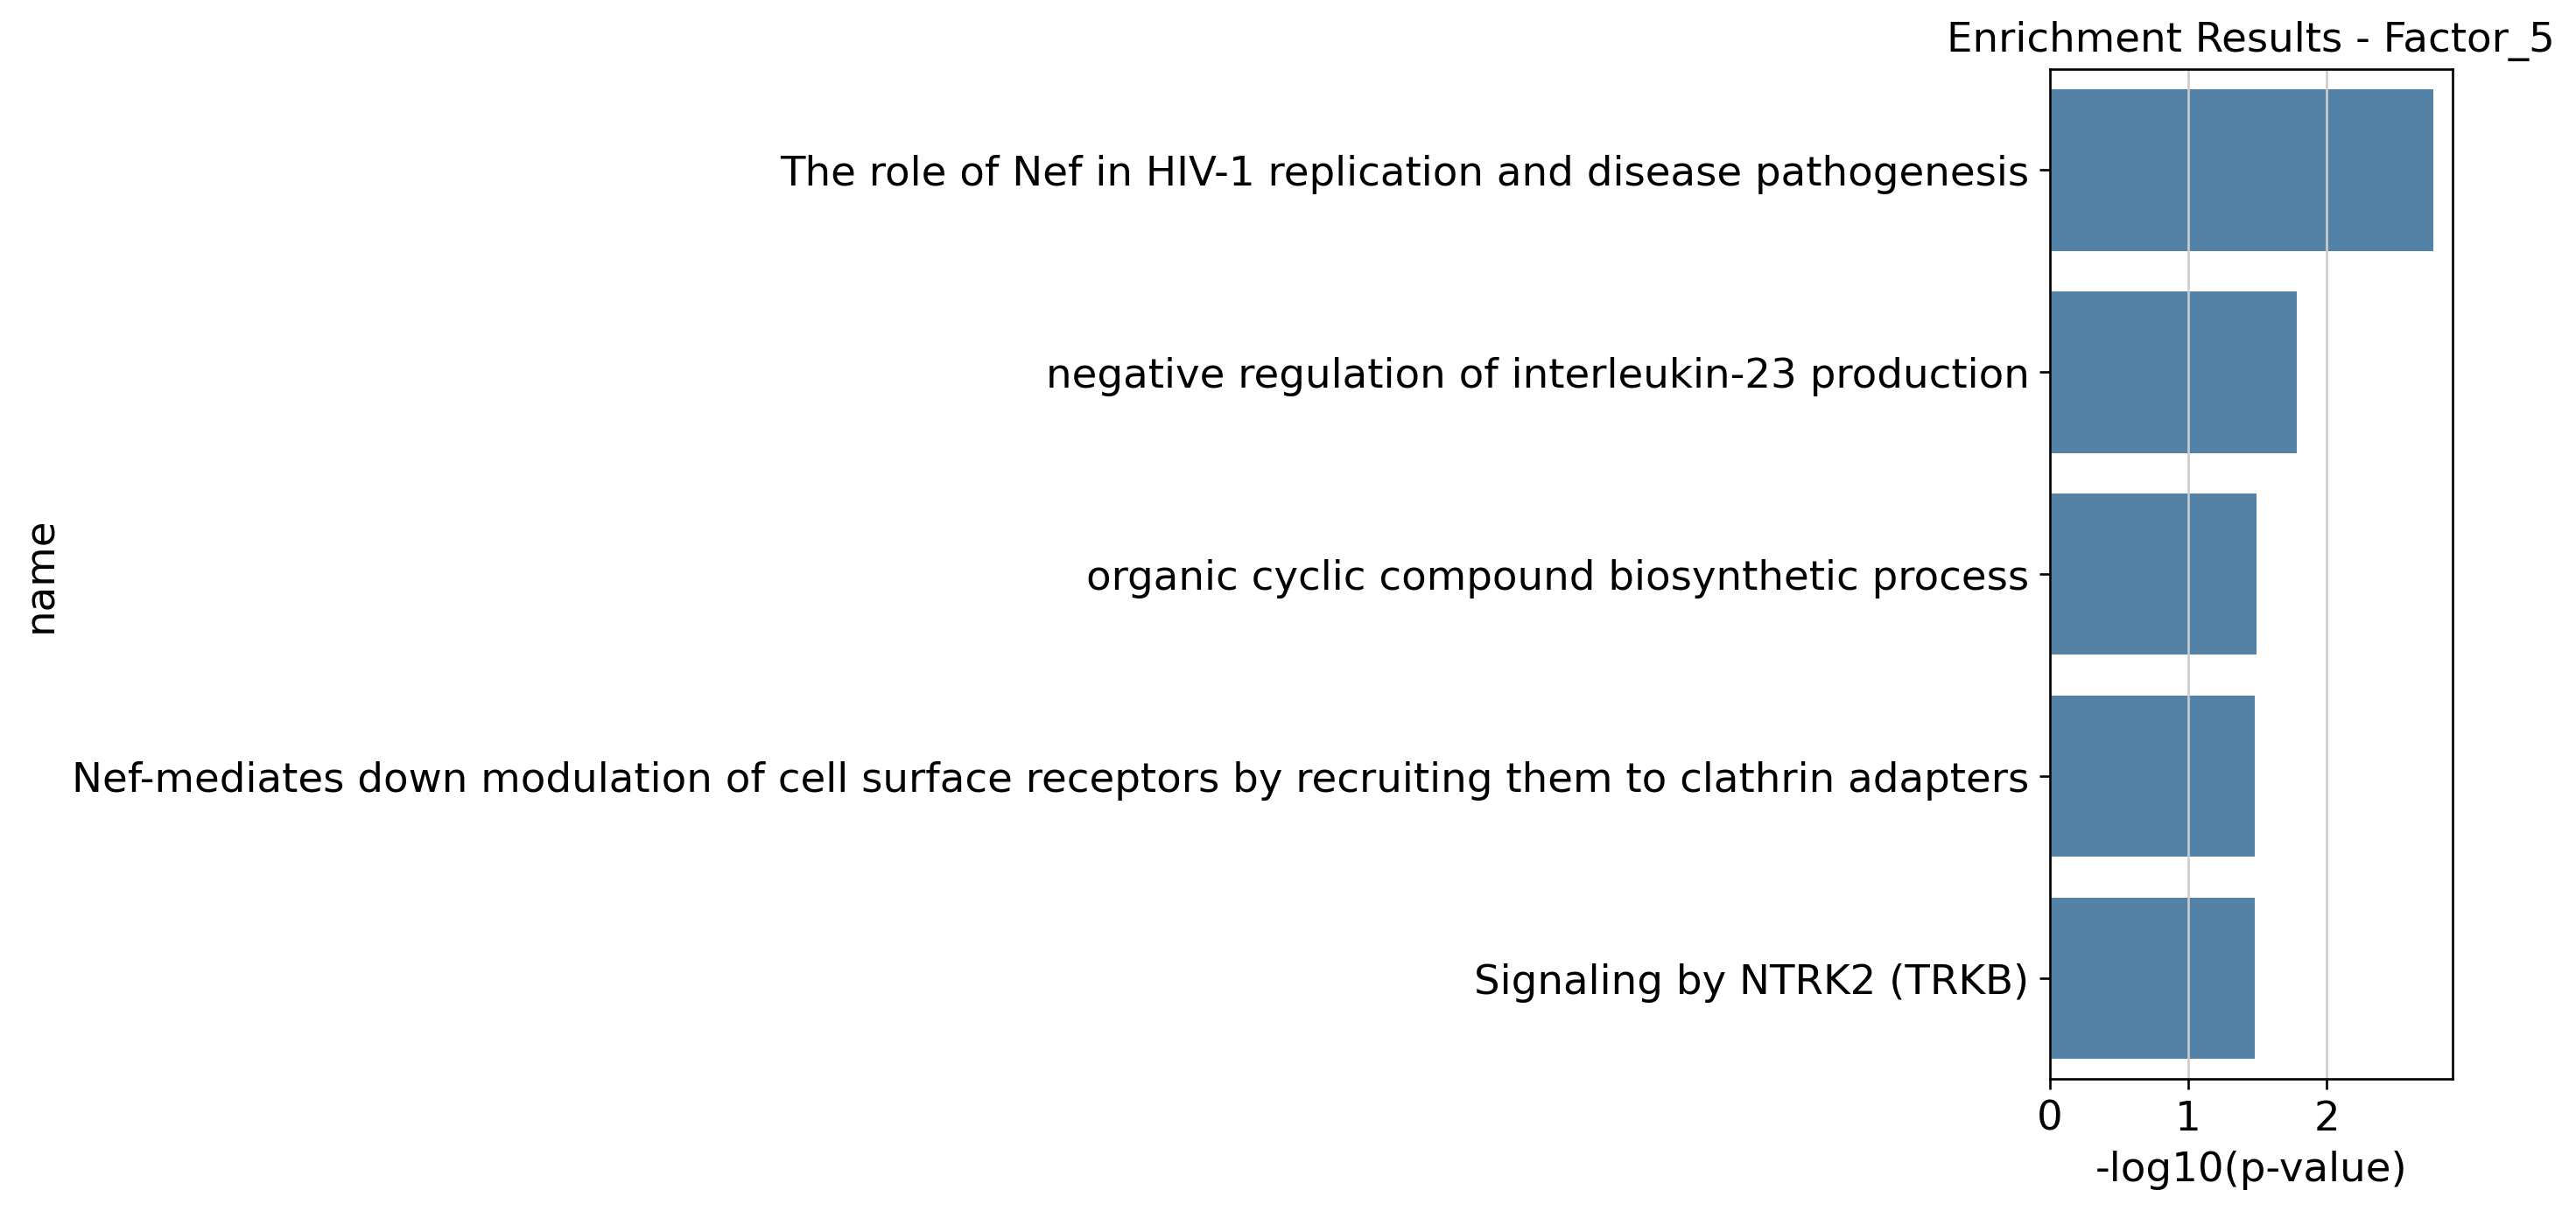

No significant enrichment for Factor_6
No significant enrichment for Factor_7
No significant enrichment for Factor_8
No significant enrichment for Factor_9
No significant enrichment for Factor_10
No significant enrichment for Factor_11
No significant enrichment for Factor_12


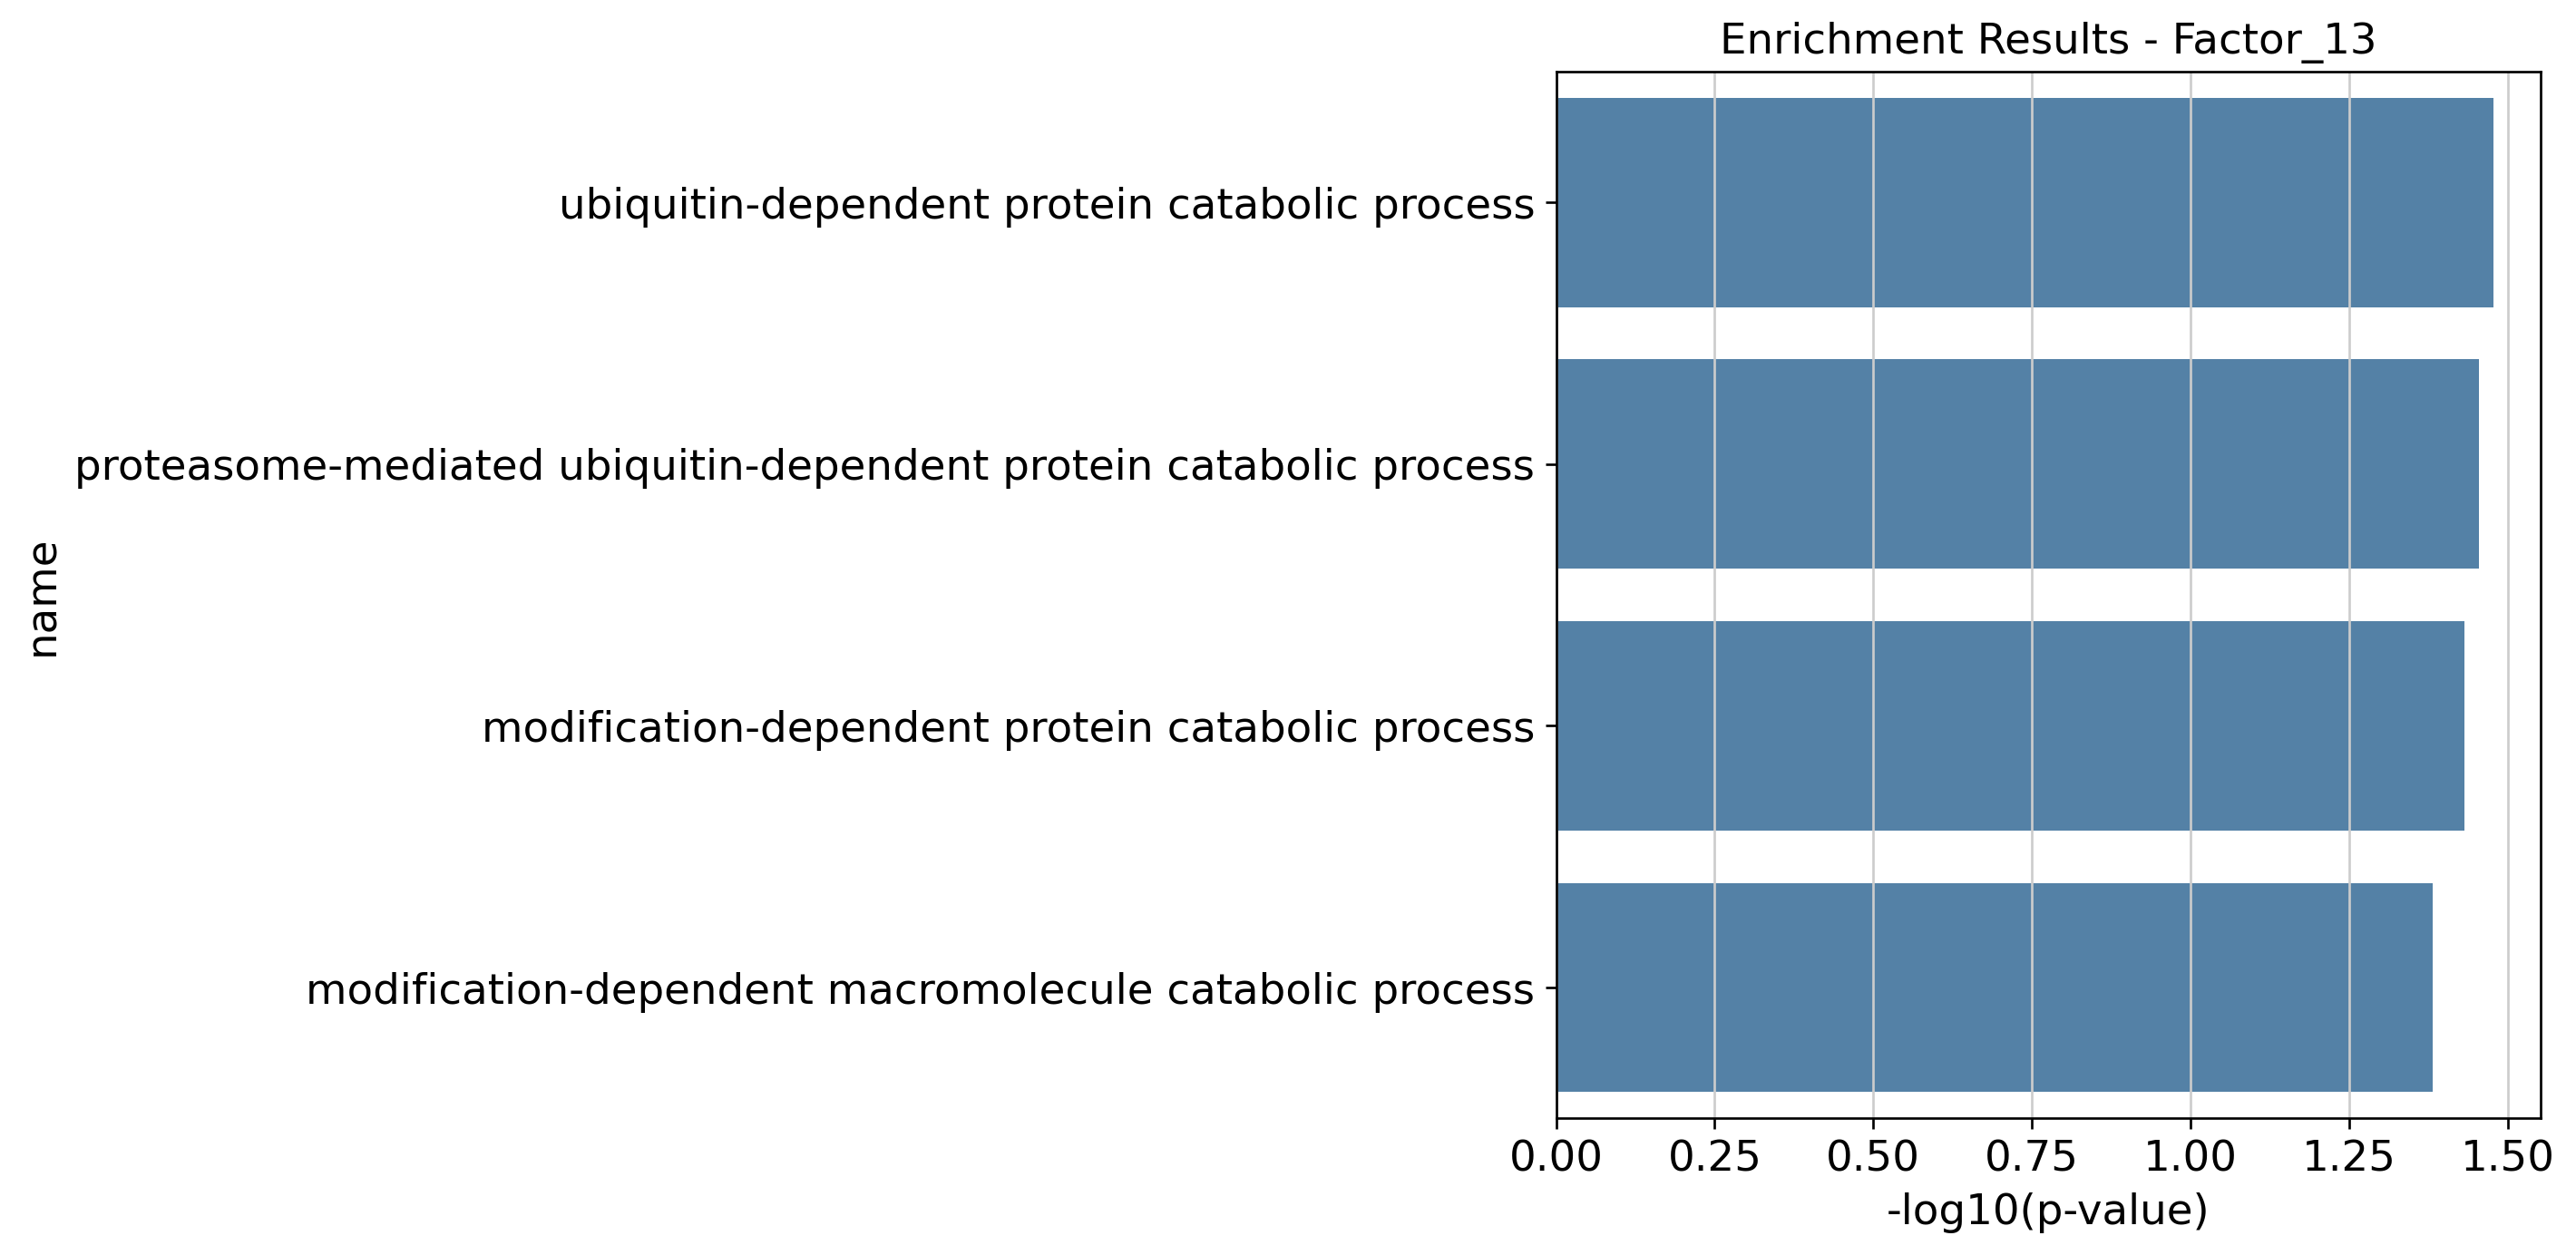

No significant enrichment for Factor_14


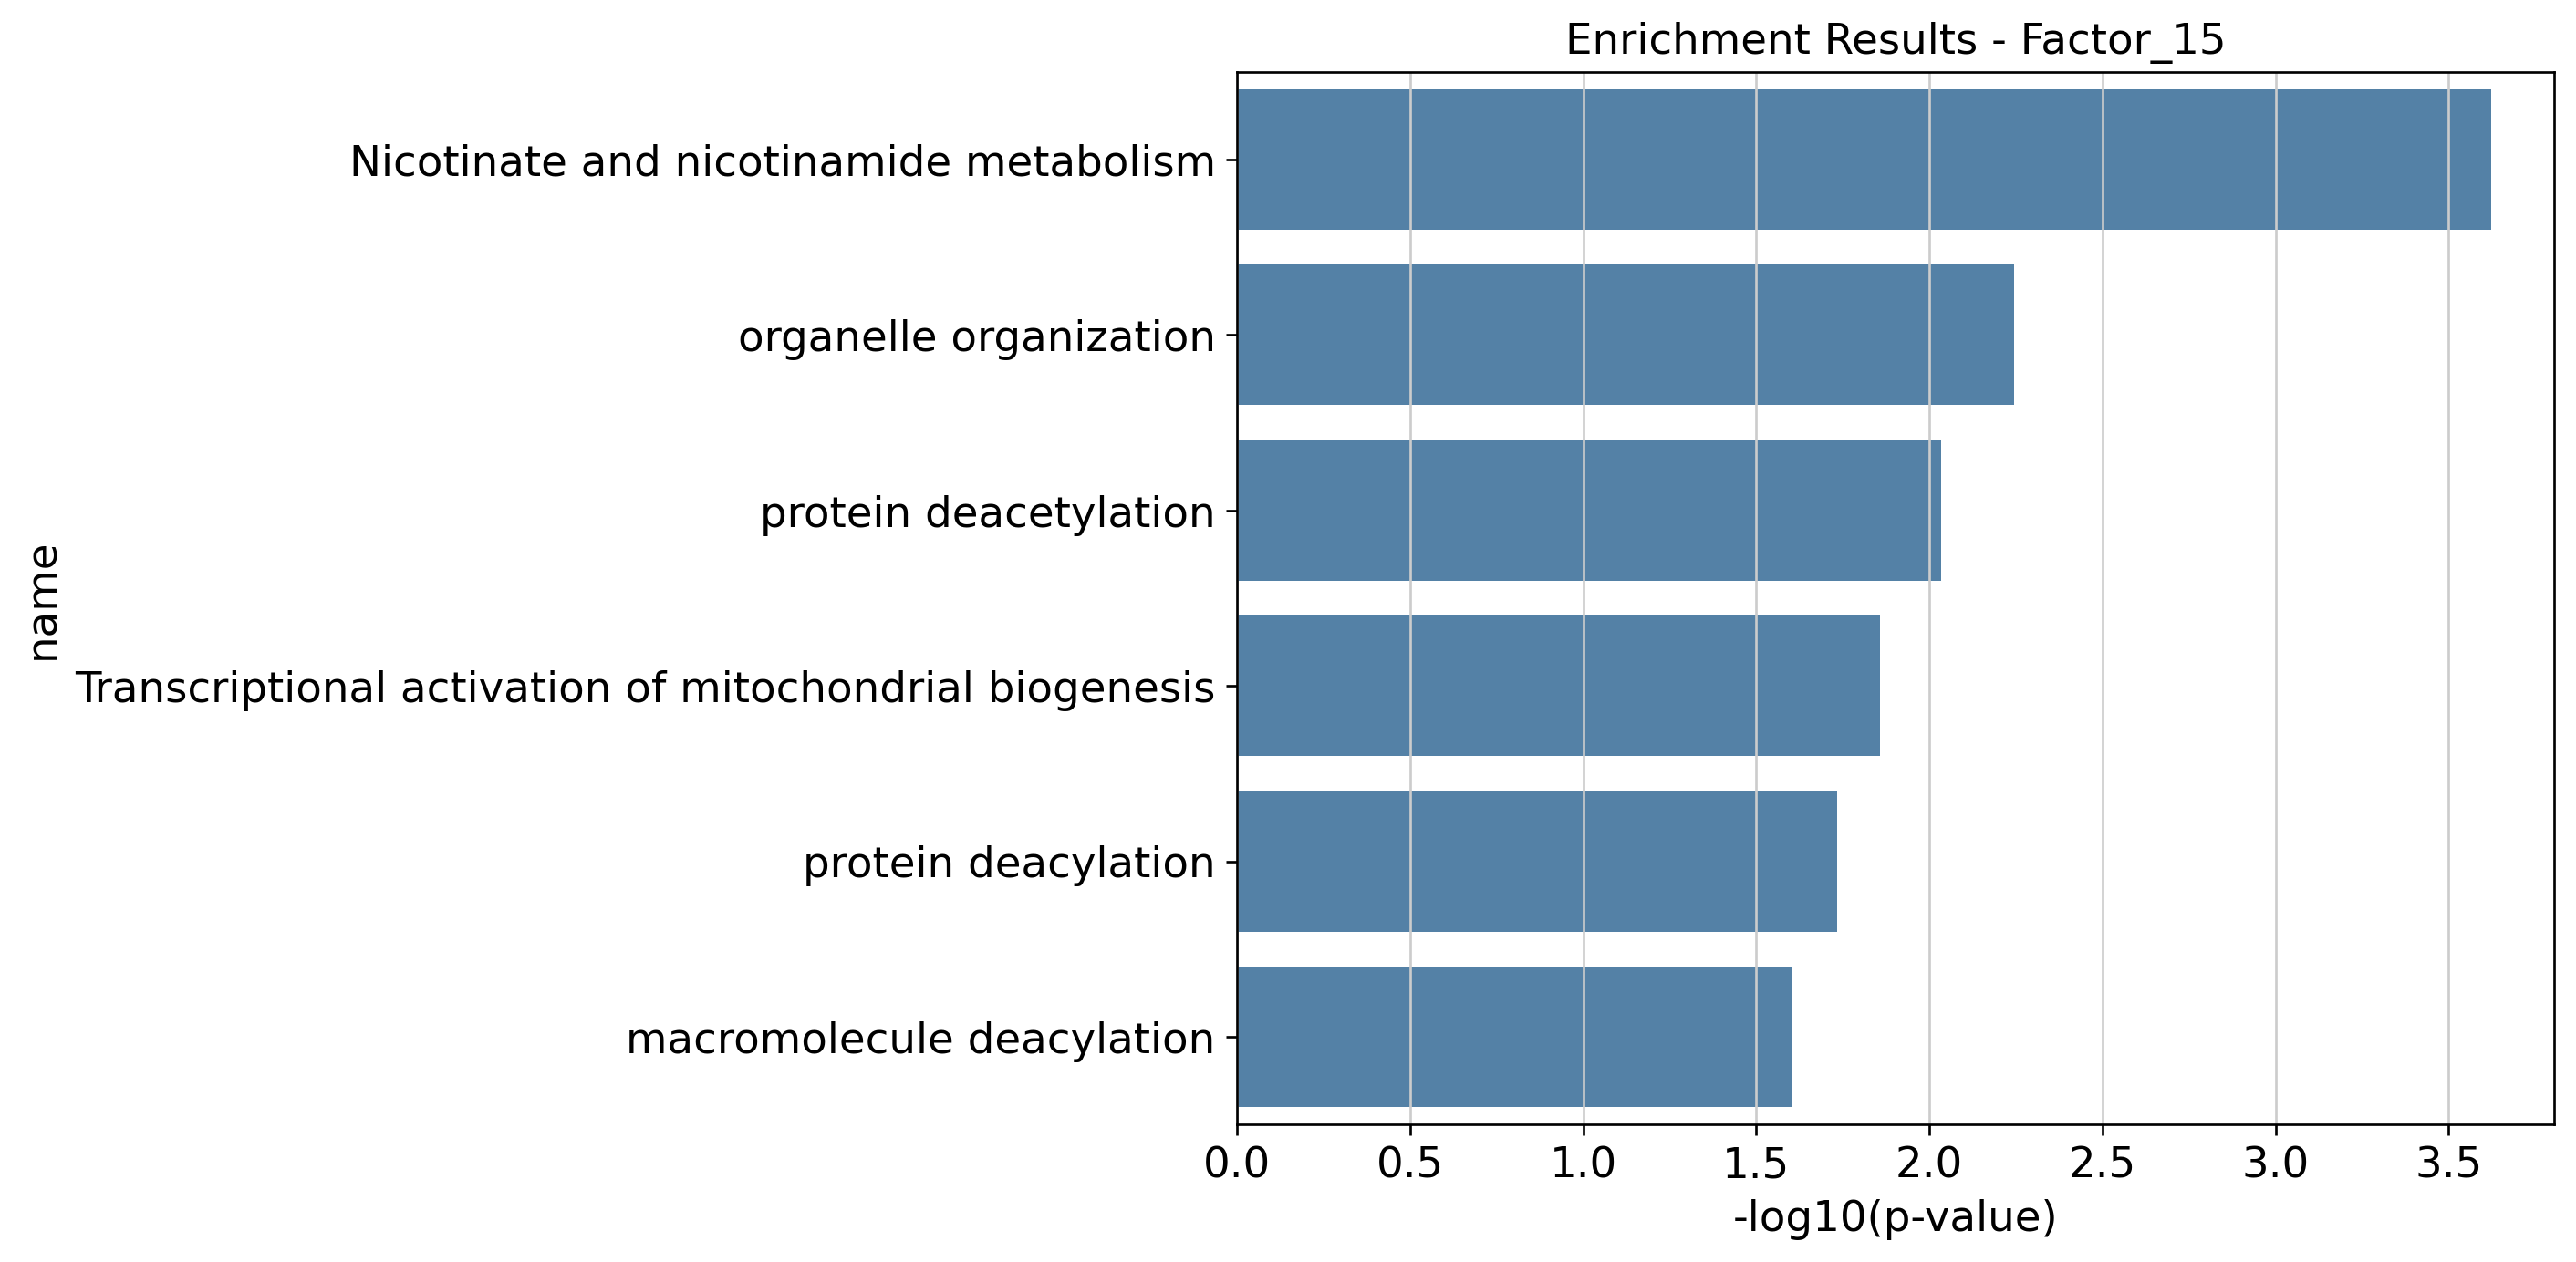

In [ ]:
def process_mofa_weights(model):
    weights = model.get_weights()
    weights_df = pd.DataFrame(weights)
    return weights_df

def get_top_features(weights_df, n_features=70):
    top_features = {}
    for factor in range(weights_df.shape[1]):
        # absolute weights
        abs_weights = np.abs(weights_df.iloc[:, factor])
        # top features
        top_indices = abs_weights.nlargest(n_features).index
        top_features[f"Factor_{factor+1}"] = top_indices.tolist()
    return top_features


def run_enrichment(features_dict):
    gp = GProfiler(return_dataframe=True)
    enrichments = {}
    
    for factor, genes in features_dict.items():
        try:
            results = gp.profile(
                query=genes,
                organism='hsapiens',
                sources=['GO:BP', 'KEGG', 'REAC'],
                user_threshold=0.05
            )
            # Add -log10(p-value) column
            results['neglog10pval'] = -np.log10(results['p_value'])
            enrichments[factor] = results
        except Exception as e:
            print(f"Error in enrichment for {factor}: {str(e)}")
            enrichments[factor] = pd.DataFrame()
            
    return enrichments

# Visualization function
def plot_enrichment(factor, results, top_n=10):
    if len(results) == 0:
        print(f"No significant enrichment for {factor}")
        return
        
    plt.figure(figsize=(12, 6))
    plot_df = results.nsmallest(top_n, 'p_value')
    
    sns.barplot(data=plot_df, 
                y='name',
                x='neglog10pval',
                color='steelblue')
    
    plt.title(f'Enrichment Results - {factor}')
    plt.xlabel('-log10(p-value)')
    plt.tight_layout()
    plt.show()

# execution of analysis
weights_df = process_mofa_weights(model)
top_features = get_top_features(weights_df)
enrichment_results = run_enrichment(top_features)

# Result-plotting
for factor, results in enrichment_results.items():
    plot_enrichment(factor, results)

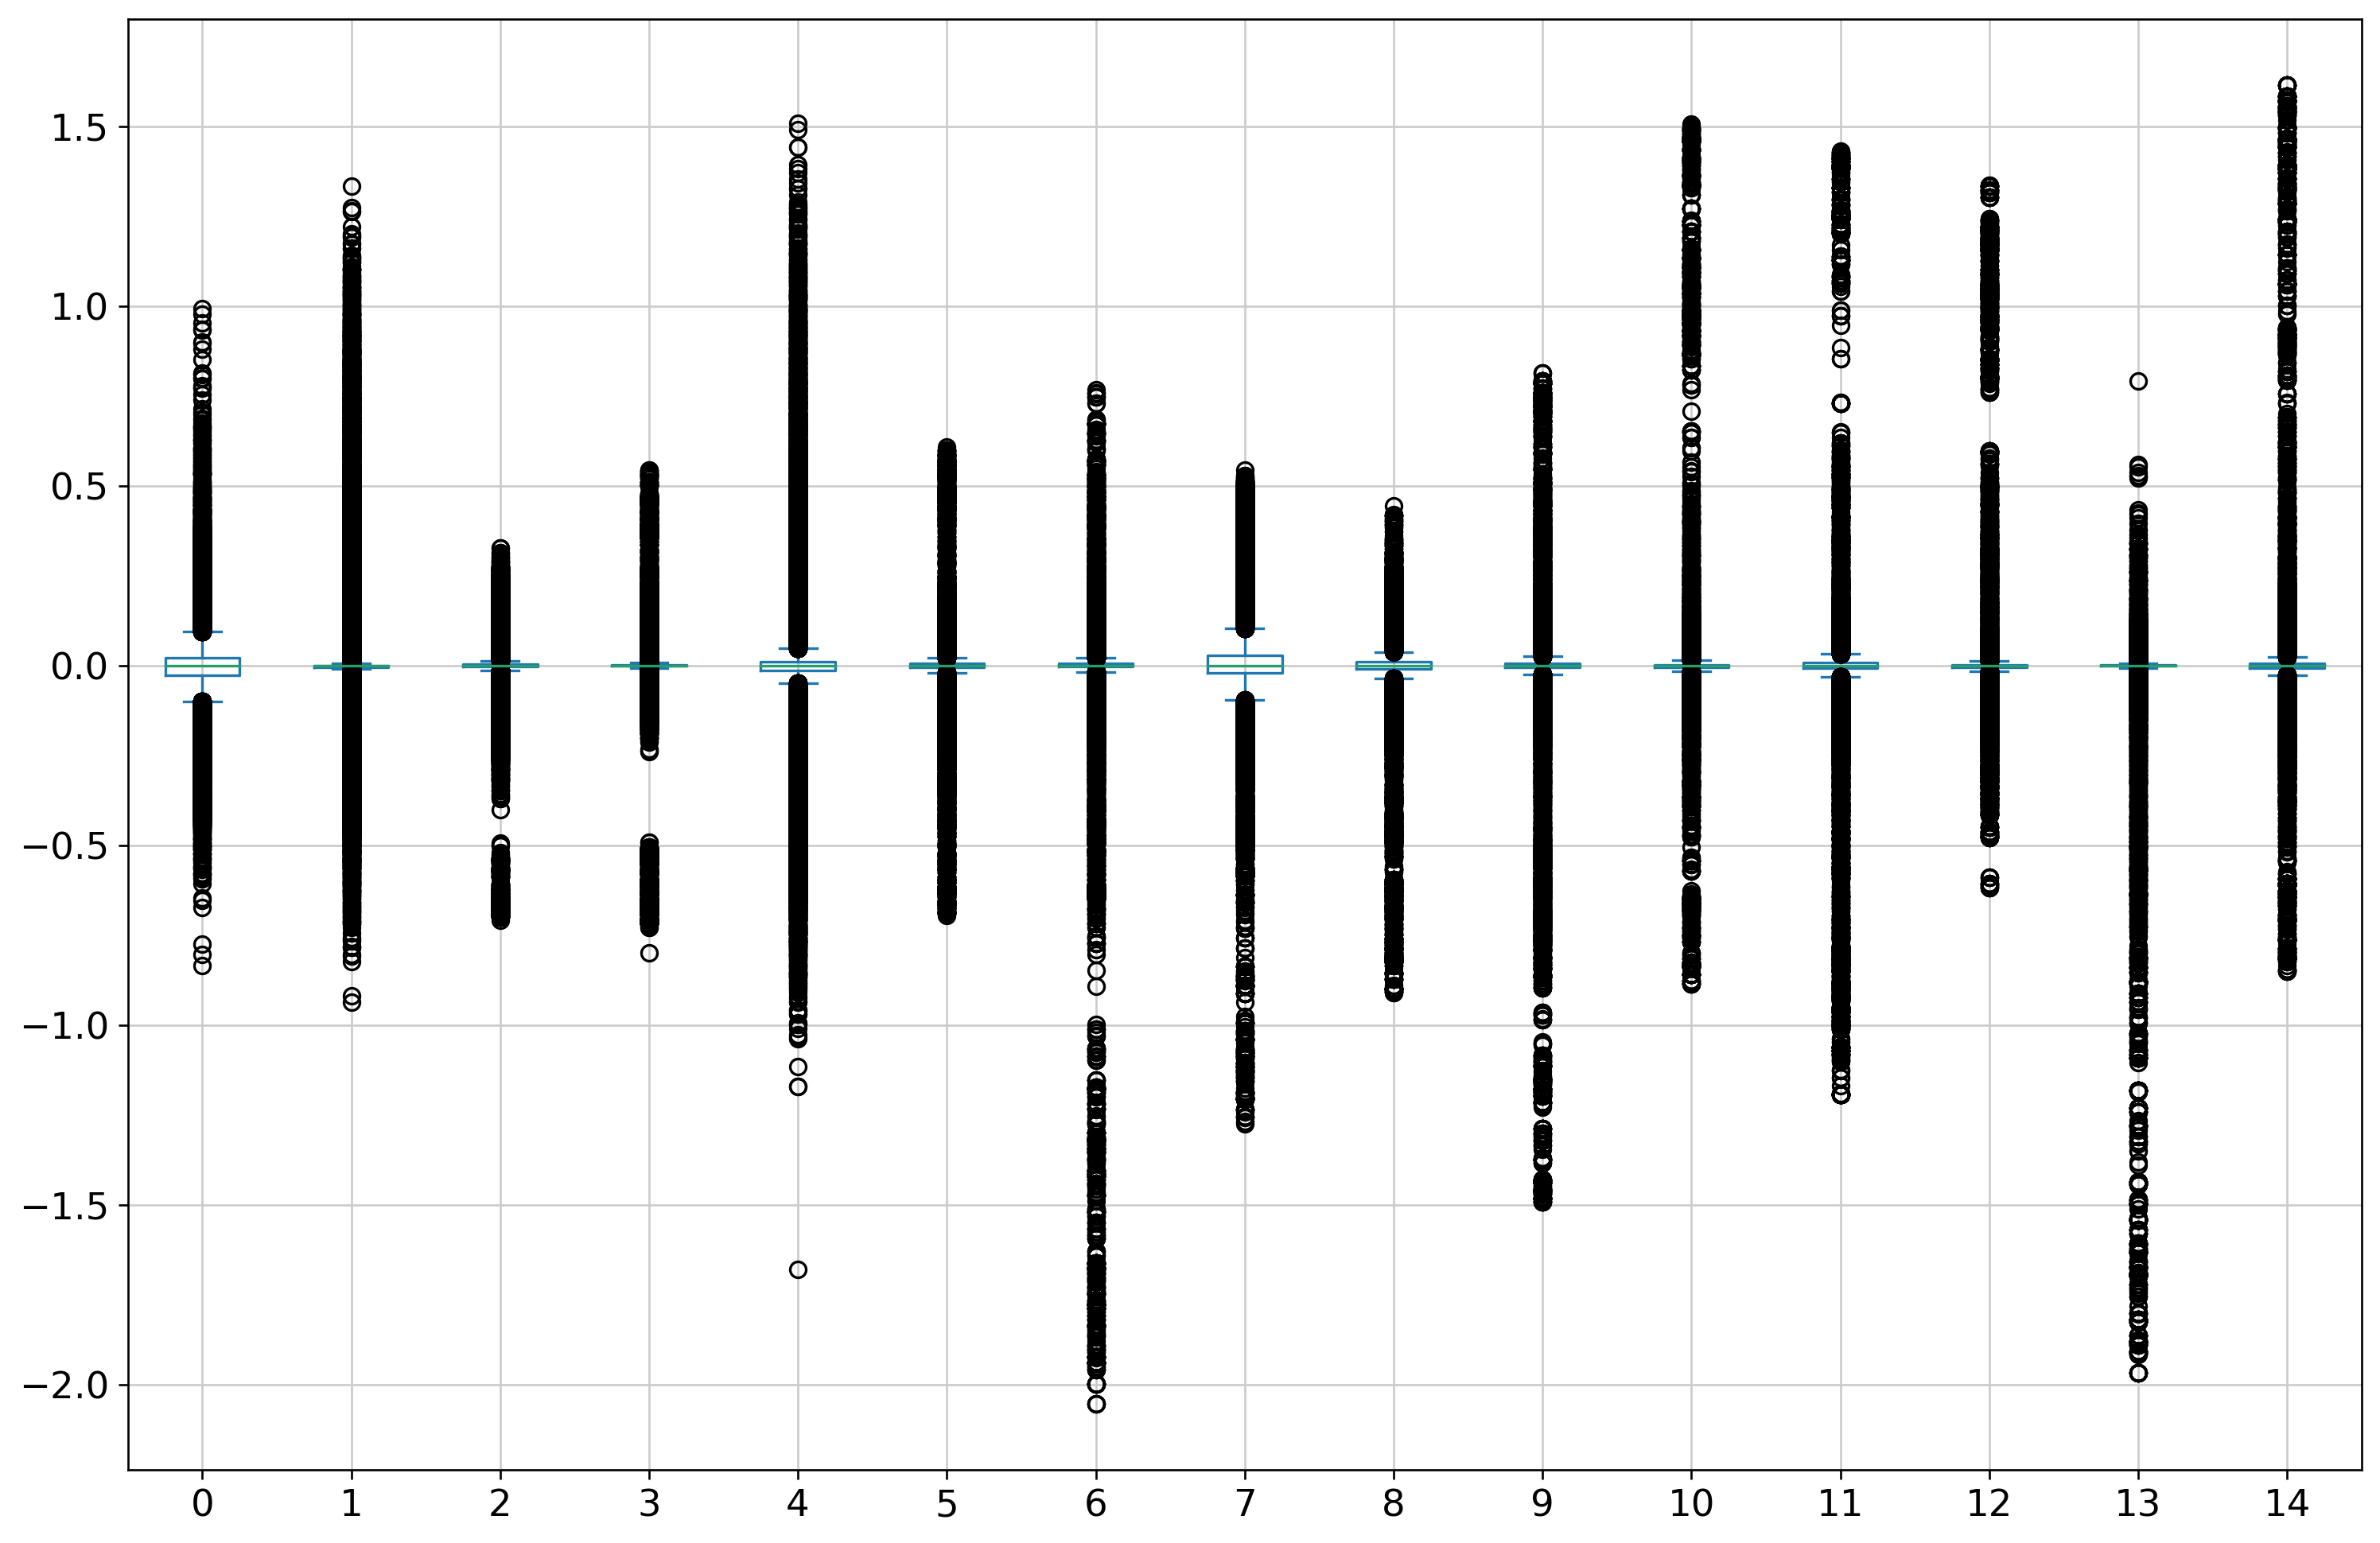

In [46]:
ax =  weights_df.plot(kind='box', figsize=(15, 10))

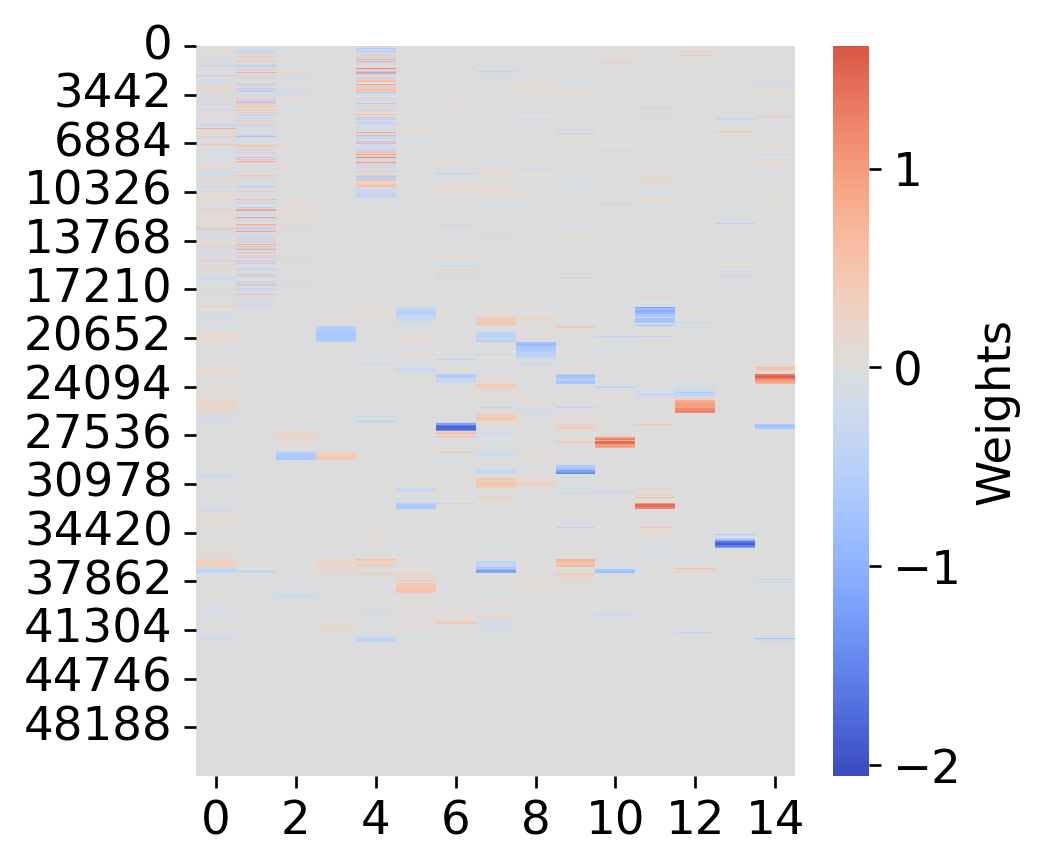

In [47]:
ax = sns.heatmap(weights_df, cmap='coolwarm', center=0, cbar_kws={'label': 'Weights'})

<AxesSubplot: xlabel='Feature rank', ylabel='Factor1 weight'>

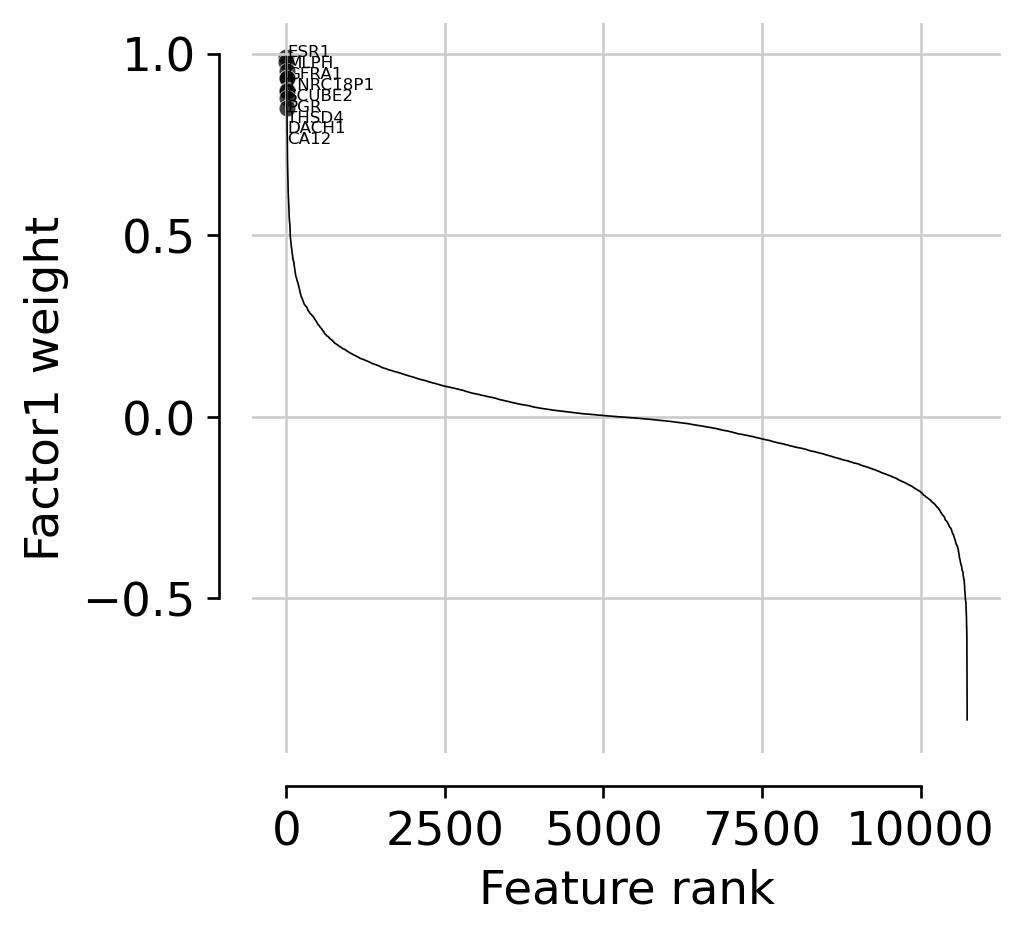

In [12]:
mfx.plot_weights_ranked(model)

<AxesSubplot: >

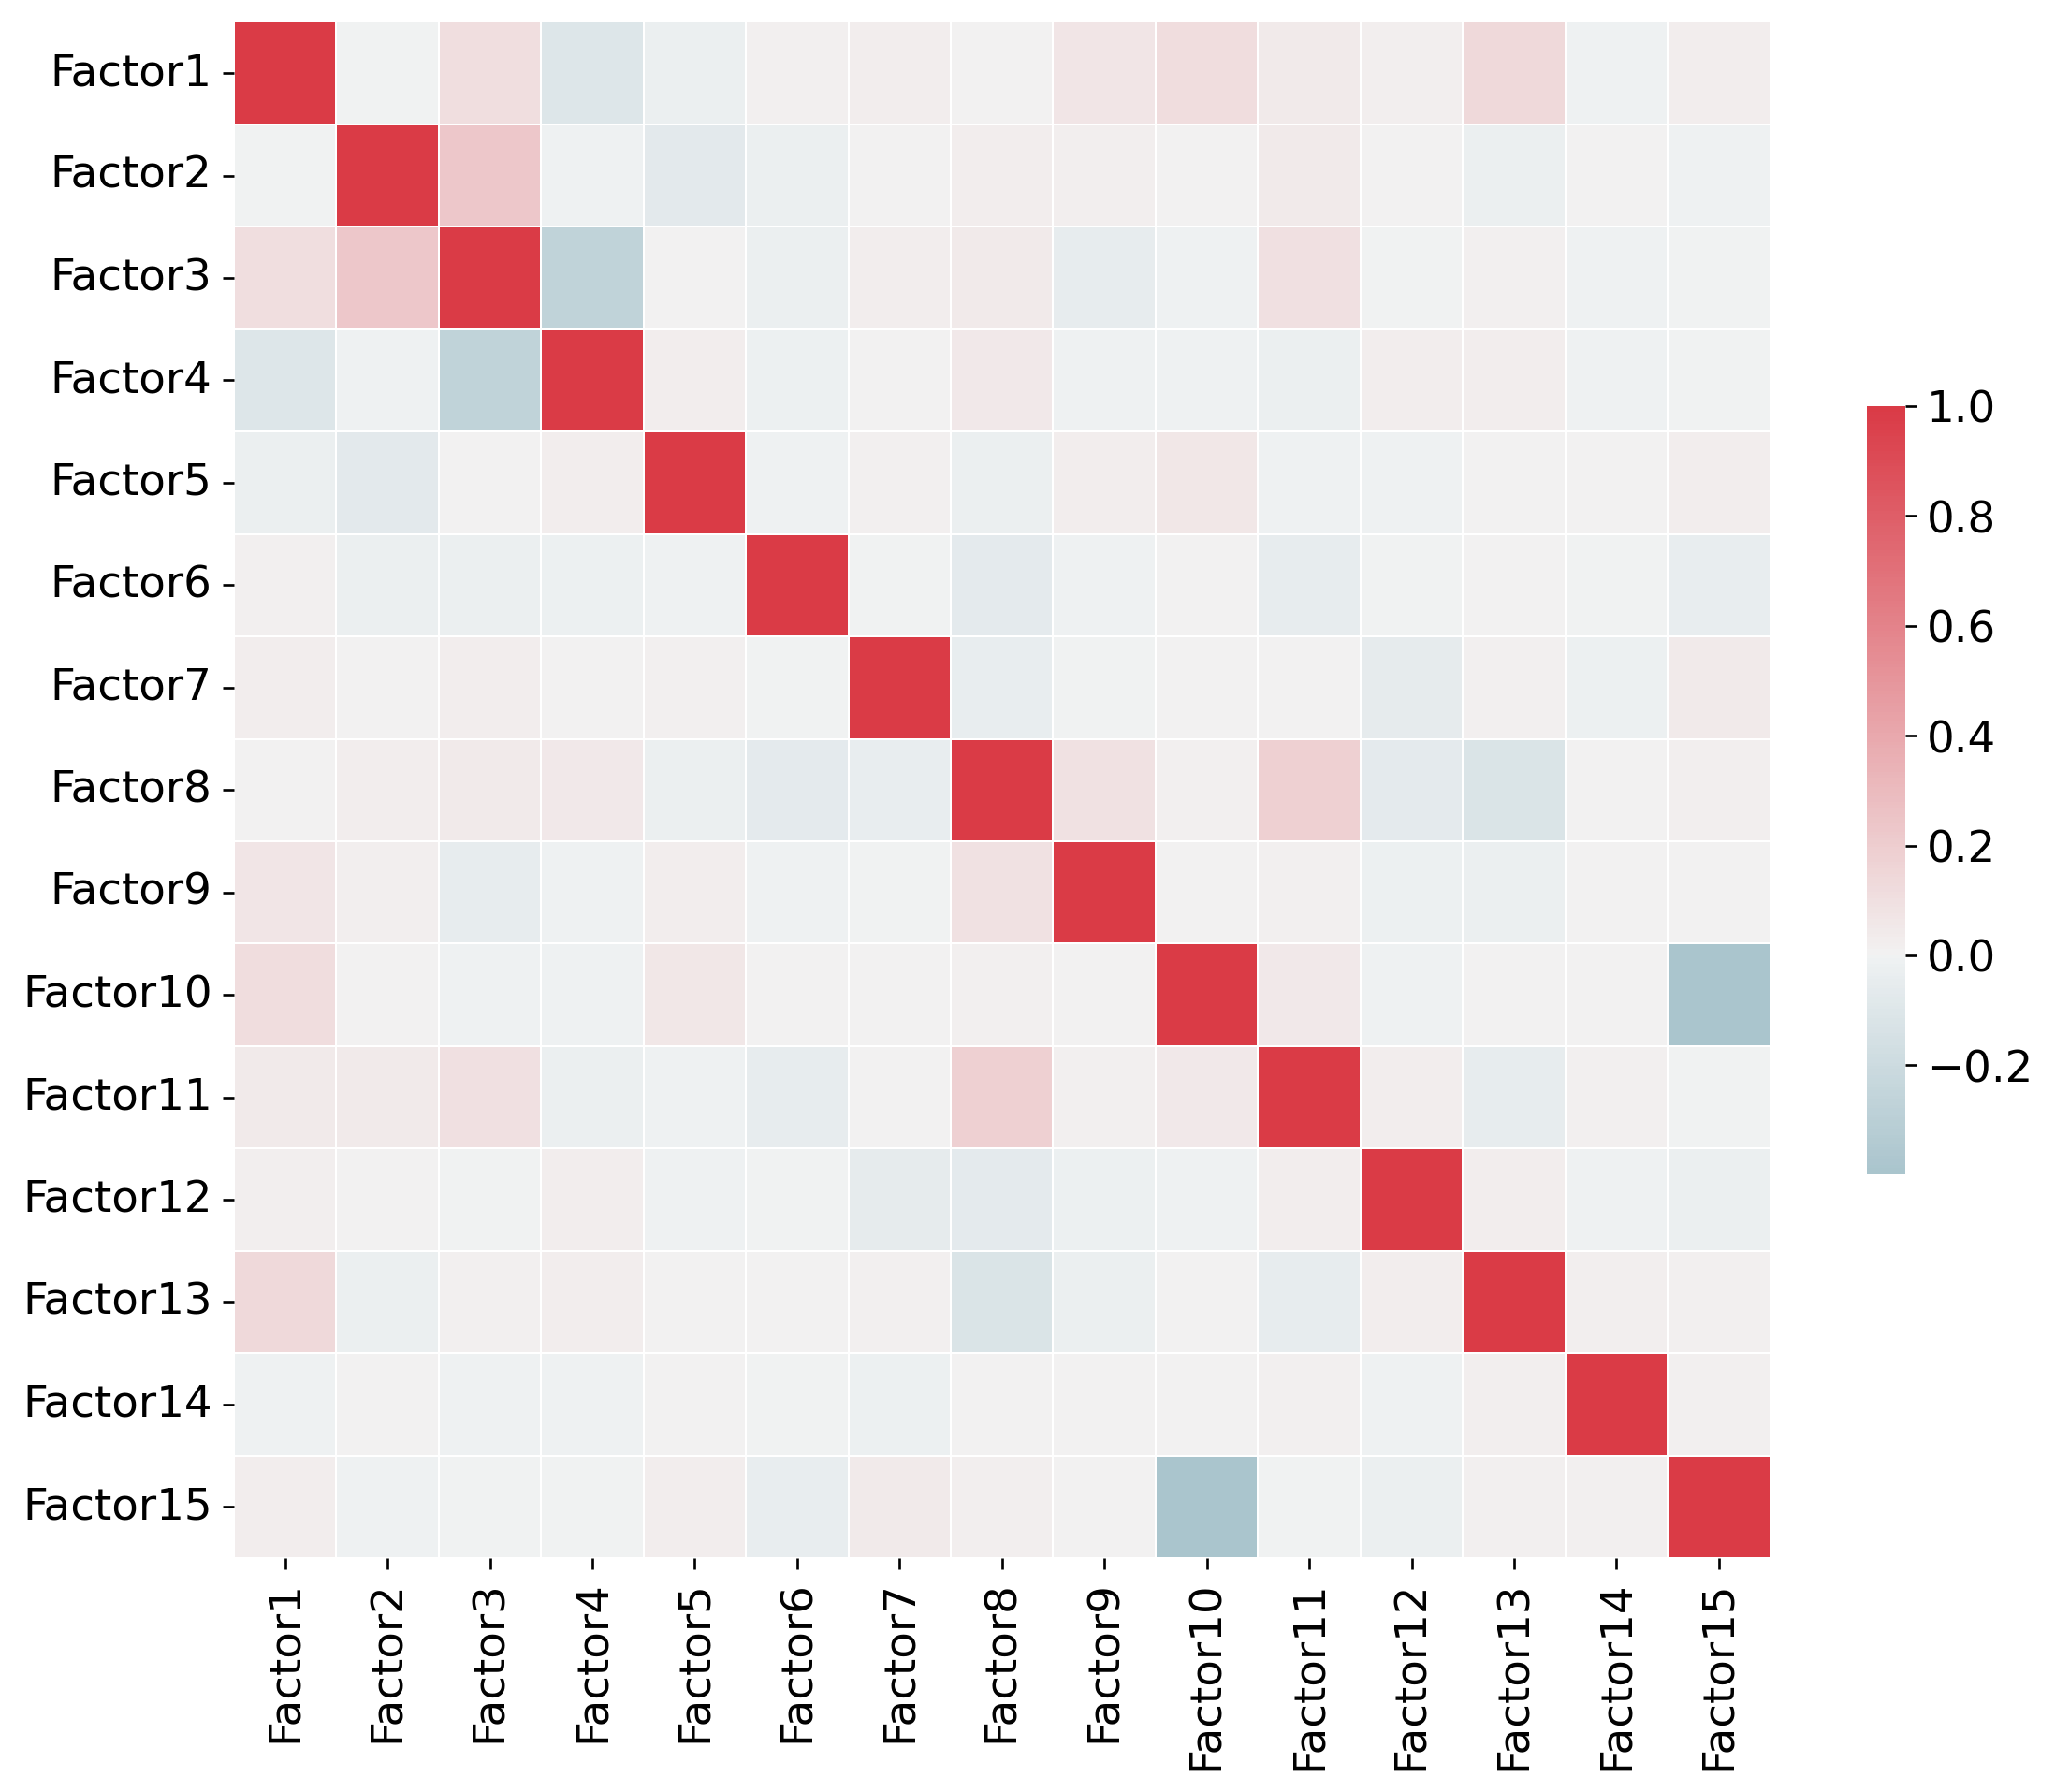

In [13]:
mfx.plot_weights_correlation(model)